In [12]:
import fastf1
import pandas as pd
import matplotlib.pyplot as plt
import os

In [13]:
fastf1.Cache.enable_cache('data/cache')
fastf1.set_log_level('ERROR')

In [14]:
# Event Schedule für 2025 laden
all_events = fastf1.get_event_schedule(2025, include_testing=False)

# Liste für alle Starting Grids
all_team_standings = []
all_race_results = []
all_weather = []

# Durch alle Events iterieren
for index, event in all_events.iterrows():
    try:
        # Rennsession laden
        session = fastf1.get_session(2025, event['EventName'], 'R')
        session.load()

        weather = session.weather_data

        weather_summary = {
            'EventName': event['EventName'],
            'RoundNumber': event['RoundNumber'],
            'AirTemp_Avg': weather['AirTemp'].mean(),
            'TrackTemp_Avg': weather['TrackTemp'].mean(),
            'Humidity_Avg': weather['Humidity'].mean(),
            'Rainfall': 1 if weather['Rainfall'].max() > 0 else 0
        }
        
        # Starting Grid extrahieren
        team_results = session.results[['TeamName', 'Points']].copy()
        race_result = session.results[['DriverNumber', 'Abbreviation', 'Position', 'Status', 'GridPosition', 'TeamName']].copy()

        team_points = team_results.groupby('TeamName')['Points'].sum().reset_index()
        team_points.columns = ['TeamName', 'RacePoints']
        
        # Event-Info hinzufügen
        team_points['EventName'] = event['EventName']
        team_points['RoundNumber'] = event['RoundNumber']
        team_points['EventDate'] = event['EventDate']
        race_result['EventName'] = event['EventName']
        race_result['RoundNumber'] = event['RoundNumber']
        race_result['EventDate'] = event['EventDate']
        
        all_weather.append(weather_summary)
        all_team_standings.append(team_points)
        all_race_results.append(race_result)
        print(f"✓ {event['EventName']} geladen")
        
    except Exception as e:
        print(f"✗ Fehler bei {event['EventName']}: {e}")

# Alle Team-Standings kombinieren
df_team_standings = pd.concat(all_team_standings, ignore_index=True)

# Kumulierte Punkte berechnen (WM-Stand)
df_team_standings = df_team_standings.sort_values(['TeamName', 'RoundNumber'])
df_team_standings['CumulativePoints'] = df_team_standings.groupby('TeamName')['RacePoints'].cumsum()

# Nach Event und Punkten sortieren
df_team_standings = df_team_standings.sort_values(['RoundNumber', 'CumulativePoints'], ascending=[True, False])

df_all_race_results = pd.concat(all_race_results, ignore_index=True)
df_all_race_results = df_all_race_results.sort_values(['RoundNumber', 'Position'])

df_weather = pd.DataFrame(all_weather)

✓ Australian Grand Prix geladen
✓ Chinese Grand Prix geladen
✓ Japanese Grand Prix geladen
✓ Bahrain Grand Prix geladen
✓ Saudi Arabian Grand Prix geladen
✓ Miami Grand Prix geladen
✓ Emilia Romagna Grand Prix geladen
✓ Monaco Grand Prix geladen
✓ Spanish Grand Prix geladen
✓ Canadian Grand Prix geladen
✓ Austrian Grand Prix geladen
✓ British Grand Prix geladen
✓ Belgian Grand Prix geladen
✓ Hungarian Grand Prix geladen
✓ Dutch Grand Prix geladen
✓ Italian Grand Prix geladen
✓ Azerbaijan Grand Prix geladen
✓ Singapore Grand Prix geladen
✓ United States Grand Prix geladen
✓ Mexico City Grand Prix geladen
✓ São Paulo Grand Prix geladen
✗ Fehler bei Las Vegas Grand Prix: The data you are trying to access has not been loaded yet. See `Session.load`
✗ Fehler bei Qatar Grand Prix: The data you are trying to access has not been loaded yet. See `Session.load`
✗ Fehler bei Abu Dhabi Grand Prix: The data you are trying to access has not been loaded yet. See `Session.load`


In [15]:
# DataFrame nach Team und RoundNumber sortieren
df_team_standings = df_team_standings.sort_values(['TeamName', 'RoundNumber'])

# Durchschnittliche Punkte der letzten 3 Rennen berechnen
df_team_standings['TeamForm_Last3'] = (
    df_team_standings.groupby('TeamName')['RacePoints']
    .rolling(window=3, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

# Auf 2 Dezimalstellen runden
df_team_standings['TeamForm_Last3'] = df_team_standings['TeamForm_Last3'].round(2)

df_team_standings[df_team_standings['RoundNumber'] == 8].sort_values('RacePoints', ascending=False)

,TeamName,RacePoints,EventName,RoundNumber,EventDate,CumulativePoints,TeamForm_Last3
75,McLaren,40.0,Monaco Grand Prix,8,2025-05-25,296.0,38.67
72,Ferrari,28.0,Monaco Grand Prix,8,2025-05-25,124.0,19.33
77,Racing Bulls,12.0,Monaco Grand Prix,8,2025-05-25,19.0,4.67
78,Red Bull Racing,12.0,Monaco Grand Prix,8,2025-05-25,134.0,17.00
73,Haas F1 Team,6.0,Monaco Grand Prix,8,2025-05-25,26.0,2.00
79,Williams,3.0,Monaco Grand Prix,8,2025-05-25,54.0,9.67
70,Alpine,0.0,Monaco Grand Prix,8,2025-05-25,6.0,0.00
71,Aston Martin,0.0,Monaco Grand Prix,8,2025-05-25,10.0,0.00
74,Kick Sauber,0.0,Monaco Grand Prix,8,2025-05-25,6.0,0.00
76,Mercedes,0.0,Monaco Grand Prix,8,2025-05-25,133.0,9.67


In [16]:
df_all_race_results[df_all_race_results['RoundNumber'] == 8]

,DriverNumber,Abbreviation,Position,Status,GridPosition,TeamName,EventName,RoundNumber,EventDate
140,4,NOR,1.0,Finished,1.0,McLaren,Monaco Grand Prix,8,2025-05-25
141,16,LEC,2.0,Finished,2.0,Ferrari,Monaco Grand Prix,8,2025-05-25
142,81,PIA,3.0,Finished,3.0,McLaren,Monaco Grand Prix,8,2025-05-25
143,1,VER,4.0,Finished,4.0,Red Bull Racing,Monaco Grand Prix,8,2025-05-25
144,44,HAM,5.0,Finished,7.0,Ferrari,Monaco Grand Prix,8,2025-05-25
145,6,HAD,6.0,Lapped,5.0,Racing Bulls,Monaco Grand Prix,8,2025-05-25
146,31,OCO,7.0,Lapped,8.0,Haas F1 Team,Monaco Grand Prix,8,2025-05-25
147,30,LAW,8.0,Lapped,9.0,Racing Bulls,Monaco Grand Prix,8,2025-05-25
148,23,ALB,9.0,Lapped,10.0,Williams,Monaco Grand Prix,8,2025-05-25
149,55,SAI,10.0,Lapped,11.0,Williams,Monaco Grand Prix,8,2025-05-25


In [17]:
# DataFrame nach Fahrer und RoundNumber sortieren
df_all_race_results = df_all_race_results.sort_values(['Abbreviation', 'RoundNumber'])

# Durchschnittliche Position der letzten 3 Rennen berechnen
df_all_race_results['Form_Last3'] = (
    df_all_race_results.groupby('Abbreviation')['Position']
    .rolling(window=3, min_periods=1)  # min_periods=1 erlaubt 1, 2 oder 3 Rennen
    .mean()
    .reset_index(level=0, drop=True)
)

# Auf 2 Dezimalstellen runden
df_all_race_results['Form_Last3'] = df_all_race_results['Form_Last3'].round(2)

# DNF basierend auf Status identifizieren
# Temporäre Variablen für die Berechnung
is_dnf = df_all_race_results['Status'].str.contains('Retired')
total_dnfs = is_dnf.groupby(df_all_race_results['Abbreviation']).cumsum()
total_races = df_all_race_results.groupby('Abbreviation').cumcount() + 1

# DNF-Rate in Prozent
df_all_race_results['DNF_Rate'] = ((total_dnfs / total_races) * 100).round(2)

df_all_race_results[df_all_race_results['RoundNumber'] == 8].sort_values('Position')

,DriverNumber,Abbreviation,Position,Status,GridPosition,TeamName,EventName,RoundNumber,EventDate,Form_Last3,DNF_Rate
140,4,NOR,1.0,Finished,1.0,McLaren,Monaco Grand Prix,8,2025-05-25,1.67,0.0
141,16,LEC,2.0,Finished,2.0,Ferrari,Monaco Grand Prix,8,2025-05-25,5.00,0.0
142,81,PIA,3.0,Finished,3.0,McLaren,Monaco Grand Prix,8,2025-05-25,2.33,0.0
143,1,VER,4.0,Finished,4.0,Red Bull Racing,Monaco Grand Prix,8,2025-05-25,3.00,0.0
144,44,HAM,5.0,Finished,7.0,Ferrari,Monaco Grand Prix,8,2025-05-25,5.67,0.0
145,6,HAD,6.0,Lapped,5.0,Racing Bulls,Monaco Grand Prix,8,2025-05-25,8.67,12.5
146,31,OCO,7.0,Lapped,8.0,Haas F1 Team,Monaco Grand Prix,8,2025-05-25,13.00,12.5
147,30,LAW,8.0,Lapped,9.0,Racing Bulls,Monaco Grand Prix,8,2025-05-25,13.00,25.0
148,23,ALB,9.0,Lapped,10.0,Williams,Monaco Grand Prix,8,2025-05-25,6.33,0.0
149,55,SAI,10.0,Lapped,11.0,Williams,Monaco Grand Prix,8,2025-05-25,9.00,25.0


In [18]:
df_all_race_results[df_all_race_results['RoundNumber'] == 11].sort_values('Position')

,DriverNumber,Abbreviation,Position,Status,GridPosition,TeamName,EventName,RoundNumber,EventDate,Form_Last3,DNF_Rate
199,4,NOR,1.0,Finished,1.0,McLaren,Austrian Grand Prix,11,2025-06-29,7.00,9.09
200,81,PIA,2.0,Finished,3.0,McLaren,Austrian Grand Prix,11,2025-06-29,2.33,0.00
201,16,LEC,3.0,Finished,2.0,Ferrari,Austrian Grand Prix,11,2025-06-29,3.67,0.00
202,44,HAM,4.0,Finished,4.0,Ferrari,Austrian Grand Prix,11,2025-06-29,5.33,0.00
203,63,RUS,5.0,Finished,5.0,Mercedes,Austrian Grand Prix,11,2025-06-29,3.33,0.00
204,30,LAW,6.0,Finished,6.0,Racing Bulls,Austrian Grand Prix,11,2025-06-29,12.00,27.27
205,14,ALO,7.0,Lapped,11.0,Aston Martin,Austrian Grand Prix,11,2025-06-29,7.67,27.27
206,5,BOR,8.0,Lapped,8.0,Kick Sauber,Austrian Grand Prix,11,2025-06-29,11.33,18.18
207,27,HUL,9.0,Lapped,20.0,Kick Sauber,Austrian Grand Prix,11,2025-06-29,7.33,0.00
208,31,OCO,10.0,Lapped,17.0,Haas F1 Team,Austrian Grand Prix,11,2025-06-29,11.67,9.09


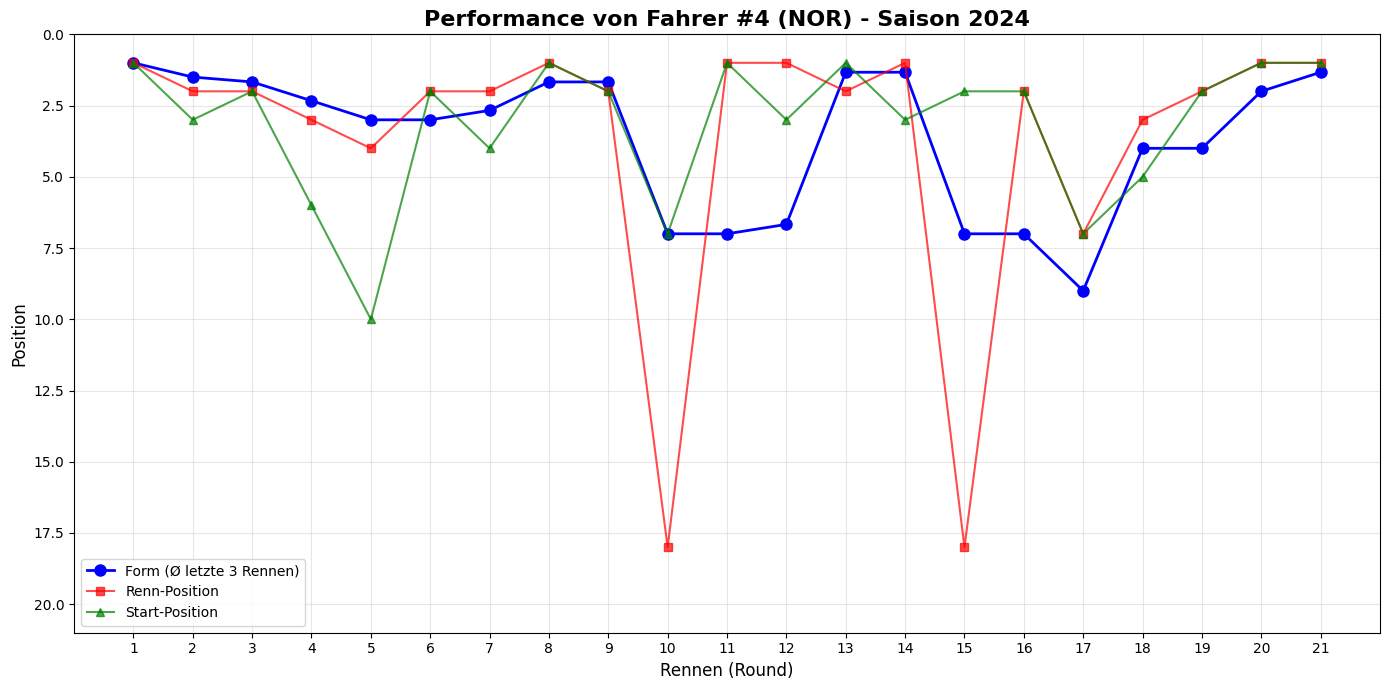

In [19]:
driver_4 = df_all_race_results[df_all_race_results['Abbreviation'] == 'NOR'].copy()

fig, ax = plt.subplots(figsize=(14, 7))
    
ax.plot(driver_4['RoundNumber'], driver_4['Form_Last3'], marker='o', linewidth=2, 
        markersize=8, label='Form (Ø letzte 3 Rennen)', color='blue')
ax.plot(driver_4['RoundNumber'], driver_4['Position'], marker='s', linewidth=1.5, 
        markersize=6, label='Renn-Position', color='red', alpha=0.7)
ax.plot(driver_4['RoundNumber'], driver_4['GridPosition'], marker='^', linewidth=1.5, 
        markersize=6, label='Start-Position', color='green', alpha=0.7)
    
ax.set_title('Performance von Fahrer #4 (NOR) - Saison 2024', fontsize=16, fontweight='bold')
ax.set_xlabel('Rennen (Round)', fontsize=12)
ax.set_ylabel('Position', fontsize=12)
ax.set_ylim(0, 21)
ax.invert_yaxis()
ax.grid(True, alpha=0.3)
ax.legend(loc='best')
ax.set_xticks(driver_4['RoundNumber'])
    
plt.tight_layout()
plt.show()

In [20]:
df_weather

,EventName,RoundNumber,AirTemp_Avg,TrackTemp_Avg,Humidity_Avg,Rainfall
0,Australian Grand Prix,1,15.707865,18.942135,78.421348,1
1,Chinese Grand Prix,2,27.215584,35.816883,18.233766,0
2,Japanese Grand Prix,3,14.430000,20.514286,76.371429,0
3,Bahrain Grand Prix,4,27.052532,31.870253,45.329114,0
4,Saudi Arabian Grand Prix,5,29.483803,37.819718,62.725352,0
5,Miami Grand Prix,6,26.573154,38.690604,63.020134,1
6,Emilia Romagna Grand Prix,7,23.964667,42.664000,38.306667,0
7,Monaco Grand Prix,8,22.209375,43.317500,52.518750,0
8,Spanish Grand Prix,9,29.120000,48.543226,54.625806,0
9,Canadian Grand Prix,10,24.036527,49.253293,27.976048,1


In [21]:
# Ordner erstellen falls nicht vorhanden
os.makedirs('data/csv', exist_ok=True)

# CSV-Dateien speichern
df_team_standings.to_csv('data/csv/test_team_standings_2025.csv', index=False)
df_all_race_results.to_csv('data/csv/test_race_results_2025.csv', index=False)
df_weather.to_csv('data/csv/test_weather_2025.csv', index=False)

print("✓ CSV-Dateien in 'data/csv/' gespeichert!")

✓ CSV-Dateien in 'data/csv/' gespeichert!


In [22]:
df_all_race_results[df_all_race_results['RoundNumber'] == 1].sort_values('Position')

,DriverNumber,Abbreviation,Position,Status,GridPosition,TeamName,EventName,RoundNumber,EventDate,Form_Last3,DNF_Rate
0,4,NOR,1.0,Finished,1.0,McLaren,Australian Grand Prix,1,2025-03-16,1.0,0.0
1,1,VER,2.0,Finished,3.0,Red Bull Racing,Australian Grand Prix,1,2025-03-16,2.0,0.0
2,63,RUS,3.0,Finished,4.0,Mercedes,Australian Grand Prix,1,2025-03-16,3.0,0.0
3,12,ANT,4.0,Finished,16.0,Mercedes,Australian Grand Prix,1,2025-03-16,4.0,0.0
4,23,ALB,5.0,Finished,6.0,Williams,Australian Grand Prix,1,2025-03-16,5.0,0.0
5,18,STR,6.0,Finished,13.0,Aston Martin,Australian Grand Prix,1,2025-03-16,6.0,0.0
6,27,HUL,7.0,Finished,17.0,Kick Sauber,Australian Grand Prix,1,2025-03-16,7.0,0.0
7,16,LEC,8.0,Finished,7.0,Ferrari,Australian Grand Prix,1,2025-03-16,8.0,0.0
8,81,PIA,9.0,Finished,2.0,McLaren,Australian Grand Prix,1,2025-03-16,9.0,0.0
9,44,HAM,10.0,Finished,8.0,Ferrari,Australian Grand Prix,1,2025-03-16,10.0,0.0
